In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(context='talk', style='ticks', color_codes=True)

%matplotlib inline

In [2]:
props = ['gap', 'homo', 'lumo', 'spectral_overlap', 'homo_extrapolated',
         'lumo_extrapolated', 'gap_extrapolated', 'optical_lumo_extrapolated']

duplicates_b3 = pd.read_csv('duplicates_b3.csv')

# Load the input data
mol_test = pd.read_csv('data/mol_test.csv')
smiles_test = pd.read_csv('smiles_data/test.csv.gz', index_col=0)

In [3]:
import pickle

with open('model_predictions.p', 'rb') as f:
    model_results = pickle.load(f)

In [4]:
model_results.keys()

dict_keys(['2d_multitarget', '2d_singletarget', 'schnet', 'schnet_uff'])

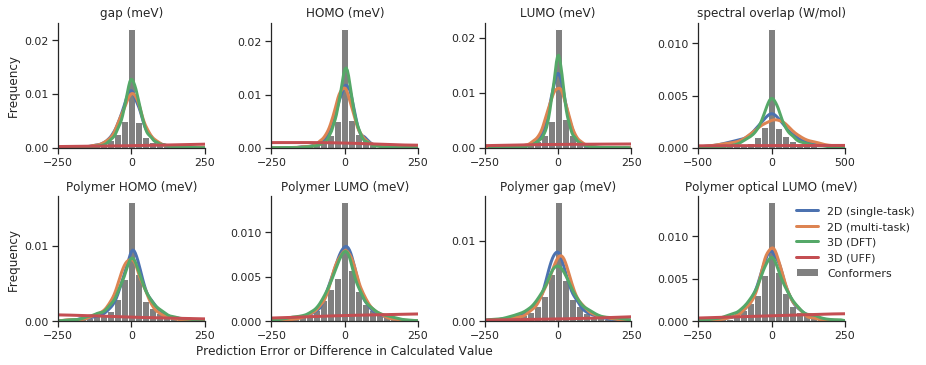

In [6]:
with sns.plotting_context('notebook'):

    fig, axmatrix = plt.subplots(nrows=2, ncols=4, figsize=(12, 5), sharey=False)

    for i, (ax, prop) in enumerate(zip(axmatrix.flatten(), props)):
        
        prop_df = duplicates_b3.loc[:, [prop + '_1', prop + '_2']].dropna()
        
        if prop is not 'spectral_overlap':
            xlim = [-250, 250]
            scale = 1000
            
        else:
            scale = 1
            xlim = [-500, 500]
            
        ax.hist((prop_df.iloc[:, 0] - prop_df.iloc[:, 1]) * scale, bins=21, range=xlim,
                density=True, color='.5', zorder=0, label='Conformers')
        ax.set_title(prop)

        
        sns.kdeplot((model_results['2d_singletarget'][prop].values - smiles_test[prop].values) * scale,
                    clip=xlim, ax=ax, label='2D (single-task)', legend=False, lw=3)
        
        sns.kdeplot((model_results['2d_multitarget'][prop].values - smiles_test[prop].values) * scale,
                    clip=xlim, ax=ax, label='2D (multi-task)', legend=False, lw=3)
        
        sns.kdeplot((model_results['schnet'][prop].values - mol_test[prop].values) * scale,
                    clip=xlim, label='3D (DFT)', ax=ax, legend=False, lw=3)
        
        sns.kdeplot((model_results['schnet_uff'][prop].values - mol_test[prop].values) * scale,
                    clip=None, label='3D (UFF)', ax=ax, legend=False, lw=3)
        
        ax.set_xlim(xlim)
        
    sns.despine()
    plt.tight_layout()
    
    axmatrix[-1, -1].legend(loc='upper left', frameon=False, bbox_to_anchor=(.6, 1.,))
    
    
    for ax, title in zip(axmatrix.flatten(),
                         ['gap (meV)', 'HOMO (meV)', 'LUMO (meV)', 'spectral overlap (W/mol)',
                          'Polymer HOMO (meV)', 'Polymer LUMO (meV)', 'Polymer gap (meV)',
                          'Polymer optical LUMO (meV)']):
        ax.set_title(title)
        
    axmatrix[0,0].set_ylabel('Frequency')
    axmatrix[1,0].set_ylabel('Frequency')

    axmatrix[1,1].set_xlabel('Prediction Error or Difference in Calculated Value')

    plt.savefig('20190105_error_comparison.svg', transparent=True, dpi=200)